In [ ]:
install.packages("qqman")
install.packages("rrBLUP")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘calibrate’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# # A first GWAS demonstration
library("qqman")
library("rrBLUP")

In [ ]:
# Let's set a basefolder to be able to read in data from external files in a platform-independent way:
basefolder = "/content"

---

## SECTION I: READ IN GENOTYPE AND PHENOTYPE DATA

### 1 Genotypes

#### Let's read an example genotype data file:

In [ ]:
## Genotypes
genotypes <- read.csv(file.path(basefolder, "example_data/genotypes_demo.csv"), header = TRUE, check.names = FALSE)
str(genotypes) ## str() displays the internal structure of an R object

'data.frame':	187 obs. of  3500 variables:
 $ SNP_1   : int  1 1 -9 0 0 0 0 0 0 1 ...
 $ SNP_2   : int  -9 2 1 2 2 1 1 2 2 2 ...
 $ SNP_3   : int  1 1 1 1 1 2 2 -9 2 2 ...
 $ SNP_4   : int  2 2 2 2 2 -9 2 1 2 2 ...
 $ SNP_5   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ SNP_6   : int  2 2 2 2 2 2 2 2 2 2 ...
 $ SNP_7   : int  0 0 0 1 0 -9 0 0 0 0 ...
 $ SNP_8   : int  1 1 1 1 1 2 2 0 2 2 ...
 $ SNP_9   : int  2 1 2 1 1 2 2 2 2 2 ...
 $ SNP_10  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ SNP_11  : int  2 2 2 -9 2 -9 2 -9 2 2 ...
 $ SNP_12  : int  2 2 2 2 2 -9 2 2 2 -9 ...
 $ SNP_13  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ SNP_14  : int  2 2 0 -9 2 1 1 -9 2 2 ...
 $ SNP_15  : int  2 2 2 -9 -9 -9 2 2 2 2 ...
 $ SNP_16  : int  2 2 2 2 2 2 -9 2 2 2 ...
 $ SNP_17  : int  -9 0 0 0 2 0 0 0 0 0 ...
 $ SNP_18  : int  1 2 2 1 2 2 2 2 2 2 ...
 $ SNP_19  : int  1 1 0 2 2 -9 0 0 0 2 ...
 $ SNP_20  : int  1 1 1 0 0 1 2 2 2 0 ...
 $ SNP_21  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ SNP_22  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ SNP_23  : in

In [ ]:
dim(genotypes) # 187 individuals genotypes with 3500 SNP

genotypes[1:5, 1:5] # 0, 1, 2, -9 coding
unique(unlist(genotypes))

[1]  187 3500

,SNP_1,SNP_2,SNP_3,SNP_4,SNP_5
,<int>,<int>,<int>,<int>,<int>
ID_1,1,-9,1,2,0
ID_2,1,2,1,2,0
ID_3,-9,1,1,2,0
ID_4,0,2,1,2,0
ID_5,0,2,1,2,0


[1]  1 -9  0  2

#### Together with genotype data (SNP genotypes for each sample), we usually need also a file with information of position (chromosome, bps) for each SNP (**map file**)

In [ ]:
## Marker map - chromosome and location for each SNP
map <- read.csv(file.path(basefolder, "example_data/map_demo.csv"), header = TRUE, check.names = FALSE)
str(map)

head(map)
unique(map$chrom)

'data.frame':	3500 obs. of  3 variables:
 $ marker: chr  "SNP_1" "SNP_2" "SNP_3" "SNP_4" ...
 $ chrom : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pos   : int  1 2 3 4 5 6 7 8 9 10 ...


,marker,chrom,pos
,<chr>,<int>,<int>
1,SNP_1,1,1
2,SNP_2,1,2
3,SNP_3,1,3
4,SNP_4,1,4
5,SNP_5,1,5
6,SNP_6,1,6


[1]  1  2  3  4  5  6  7  8  9 10

### 2 Phenotypes

In [ ]:
## Phenotype data
phenotypes <- read.csv(file.path(basefolder, "example_data/phenotypes_demo.csv"), header = TRUE, check.names = FALSE)
str(phenotypes) # Phenotypes for 363 individuals and 4 traits.
head(phenotypes)

'data.frame':	187 obs. of  3 variables:
 $ Name       : chr  "ID_1" "ID_2" "ID_3" "ID_4" ...
 $ yield      : num  13.1 15.6 11.8 13.4 12.6 ...
 $ fruit_shape: num  4.71 3.59 4.07 2.81 2.81 3.73 4.73 4.85 4.46 2.54 ...


,Name,yield,fruit_shape
,<chr>,<dbl>,<dbl>
1,ID_1,13.10,4.71
2,ID_2,15.56,3.59
3,ID_3,11.77,4.07
4,ID_4,13.43,2.81
5,ID_5,12.58,2.81
6,ID_6,15.04,3.73


In [ ]:
## Check if ID order is the same in the genotypes and phenotypes data frames
rownames(genotypes) == phenotypes$Name # all ID's match
sum(rownames(genotypes) != phenotypes$Name) ## count the n. of mismatches
any(rownames(genotypes) != phenotypes$Names) ## is at least one of the logical values true?

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[121] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[136] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[151] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[166] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[181] TRUE TRUE TRUE TRUE TRUE TRUE TRUE

[1] 0

[1] FALSE

---
## SECTION II: RECODE SNP CALLS FOR rrBLUP & FILTER INDIVIDUALS AND SNP

In [ ]:
genotypes <- as.matrix(genotypes)
genotypes[which(genotypes == -9)] <- NA    # replace -9 by NA, and ...
genotypes <- genotypes - 1                 # convert to -1, 0, 1 SNP coding
genotypes[1:5, 1:5]

,SNP_1,SNP_2,SNP_3,SNP_4,SNP_5
ID_1,0,NA,0,1,-1
ID_2,0,1,0,1,-1
ID_3,NA,0,0,1,-1
ID_4,-1,1,0,1,-1
ID_5,-1,1,0,1,-1


### 1. Remove individuals with more than 20% missing marker data (80% of SNP calls are present)

A high fraction of missing markers might indicate a low genotyping quality.

In [ ]:
rm_ind <- as.matrix(rowSums(is.na(genotypes)) / ncol(genotypes)) # fraction of NA per individual
rm_ind <- 1 - rm_ind # fraction of SNP called per individual

length(which(rm_ind < 0.8)) # number of individuals with less than 80% SNP calls (at least 20% NA)
rm_ind <- (which(rm_ind < 0.8))

[1] 9

In [ ]:
rm_ind

[1]   6  51  64  72  84 124 149 180 184

In [ ]:
### Remove individuals from the genotypes AND the phenotypes object.
dim(genotypes)
dim(phenotypes)
if (length(rm_ind) > 0) genotypes <- genotypes[-rm_ind, ]
if (length(rm_ind) > 0) phenotypes <- phenotypes[-rm_ind, ]
dim(genotypes) # Individuals with too many missing markers have been removed
dim(phenotypes) # Individuals with too many missing markers have been removed

[1]  187 3500

[1] 187   3

[1]  178 3500

[1] 178   3

### 2. Remove SNP markers with more than 15% missing SNP calls (at least 15% NA per marker)

In [ ]:
rm_snp <- as.matrix(colSums(is.na(genotypes)) / nrow(genotypes))
rm_snp <- 1 - rm_snp
length(which(rm_snp < 0.85)) # number of SNP with less than 85% SNP calls.
rm_snp <- (which(rm_snp < 0.85))

[1] 89

In [ ]:
?colSums

In [ ]:
rm_snp

[1]   65   66  135  278  413  414  429  480  484  534  550  585  592  673  690
[16]  699  709  712  773  892  908  917  953 1043 1056 1133 1215 1245 1287 1290
[31] 1294 1300 1311 1460 1501 1528 1579 1666 1677 1737 1761 1788 1828 1849 1882
[46] 1901 1958 1982 2013 2070 2160 2177 2209 2242 2277 2408 2429 2481 2495 2569
[61] 2587 2595 2604 2628 2632 2656 2682 2715 2724 2758 2776 2845 2908 2940 2966
[76] 2971 3027 3047 3071 3098 3105 3187 3190 3210 3222 3298 3371 3398 3491

In [ ]:
### Remove SNP from the genotypes AND the map object.
dim(genotypes)
dim(map)
if (length(rm_snp) > 0) genotypes <- genotypes[ , -rm_snp]
if (length(rm_snp) > 0) map <- map[-rm_snp, ]
dim(genotypes) # SNP with too many missing calls have been removed
dim(map) # SNP with too many missing calls have been removed

[1]  178 3500

[1] 3500    3

[1]  178 3411

[1] 3411    3

3. Remove SNP markers falling below an MAF threshold value

In [ ]:
maf <- 0.03
maf_snp <- genotypes + 1  # reconvert to 0, 1, 2 coding to calculate allele frequency

maf_snp[1:5, 1:5]

maf_snp <- as.matrix(colSums(maf_snp, na.rm = TRUE) / (2 * nrow(maf_snp)))
head(maf_snp)

range(maf_snp) # range of allele frequencies

,SNP_1,SNP_2,SNP_3,SNP_4,SNP_5
ID_1,1,NA,1,2,0
ID_2,1,2,1,2,0
ID_3,NA,1,1,2,0
ID_4,0,2,1,2,0
ID_5,0,2,1,2,0


SNP_1,0.14887640
SNP_2,0.87359551
SNP_3,0.48595506
SNP_4,0.91011236
SNP_5,0.01685393
SNP_6,0.87921348


[1] 0.0000000 0.9775281

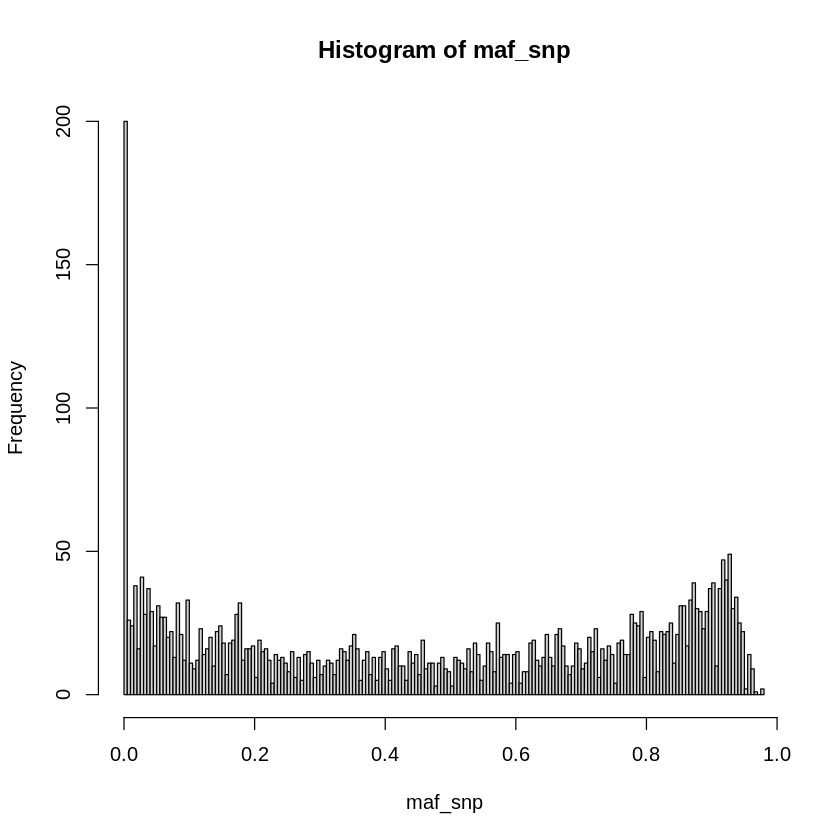

In [ ]:
hist(maf_snp, breaks = 200)

In [ ]:
maf_A <- which(maf_snp < maf)
maf_B <- which(maf_snp > (1 - maf))
rm_snp_maf <- c(maf_A, maf_B)

In [ ]:
### Remove SNP from the genotypes AND the map object.
dim(genotypes)
dim(map)
if (length(rm_snp_maf) > 0) genotypes <- genotypes[ , -rm_snp_maf]
if (length(rm_snp_maf) > 0) map <- map[-rm_snp_maf, ]
dim(genotypes)
dim(map)

[1]  178 3411

[1] 3411    3

[1]  178 3064

[1] 3064    3

## 3.2 ALTERNATIVE TO MAF - minor allele count

- Before we used a $3\%$ threshold for MAF: with 178 samples, this implies a minimum of 11 copies of the minor allele in the sampled population.
- We can be more specific and set the minimum n. of alleles we want to have for our GWAS analysis:

In [ ]:
mac <- 30 # We want the minor allele to be present with at least 30 copies in the population.
mac_snp <- genotypes + 1
mac_snp <- as.matrix(colSums(mac_snp, na.rm = TRUE)) # count allele copies

range(mac_snp) ## n_samples x 2 is the maximum value possible (e.g. 178 x 2 = 356)

[1]  11 344

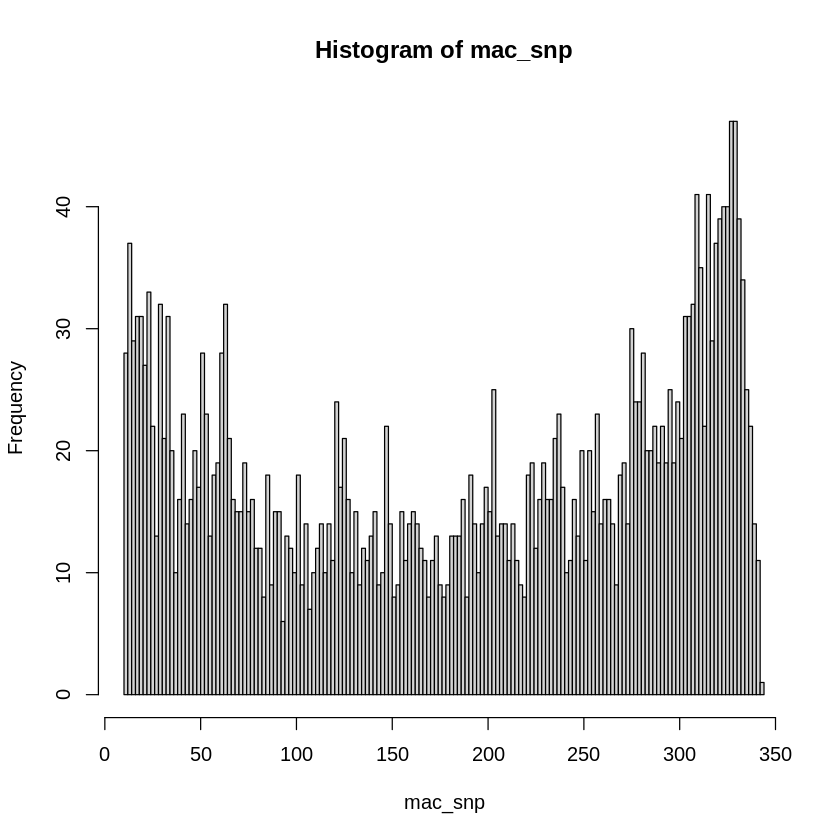

In [ ]:
hist(mac_snp, breaks = 200)

In [ ]:
mac_A <- which(mac_snp < mac)
mac_B <- which(mac_snp > (2 * nrow(genotypes) - mac))
rm_snp_mac <- c(mac_A, mac_B)

### Remove SNP from the genotypes AND the map object.
dim(genotypes)
dim(map)

[1]  178 3064

[1] 3064    3

In [ ]:
if (length(rm_snp_mac) > 0) genotypes <- genotypes[ , -rm_snp_mac]
if (length(rm_snp_mac) > 0) map <- map[-rm_snp_mac, ]
dim(genotypes)
dim(map)

[1]  178 2563

[1] 2563    3

---
## SECTION III: IMPUTE MISSING MARKERS AND GENERATE THE GENOMIC RELATIONSHIP MATRIX

When we use **rrBLUP to generate the genomic relationship matrix**, we can:
- filter for MAF,
- remove markers with too many missing calls,
- choose between two imputation methods; we choose a simple mean imputation here.

Note: we included NA's (all individuals) in the calculation of allele frequencies. rrBLUP
only includes individuals with successful calls in the calculation of allele frequencies
(NA's are excluded). This can result in different marker numbers after filtering.

In [ ]:
grm <- rrBLUP::A.mat(genotypes,
                     min.MAF = 0.05,
                     max.missing = 1,
                     impute.method = "mean",
                     return.imputed = TRUE)

In [ ]:
g_mat_imputed <- grm$imputed # SNP matrix with imputed missing values
grm <- grm$A # genomic relationship matrix

genotypes[1:5, 1:5]     # pre imputation, and ...
g_mat_imputed[1:5, 1:5] # post imputation.
dim(genotypes)
dim(g_mat_imputed)

,SNP_1,SNP_2,SNP_3,SNP_4,SNP_6
ID_1,0,NA,0,1,1
ID_2,0,1,0,1,1
ID_3,NA,0,0,1,1
ID_4,-1,1,0,1,1
ID_5,-1,1,0,1,1


,SNP_1,SNP_3,SNP_6,SNP_7,SNP_8
ID_1,-5.551115e-17,0,1,-1.000000e+00,0
ID_2,-5.551115e-17,0,1,-1.000000e+00,0
ID_3,-6.787879e-01,0,1,-1.000000e+00,0
ID_4,-1.000000e+00,0,1,5.551115e-17,0
ID_5,-1.000000e+00,0,1,-1.000000e+00,0


[1]  178 2563

[1]  178 2318

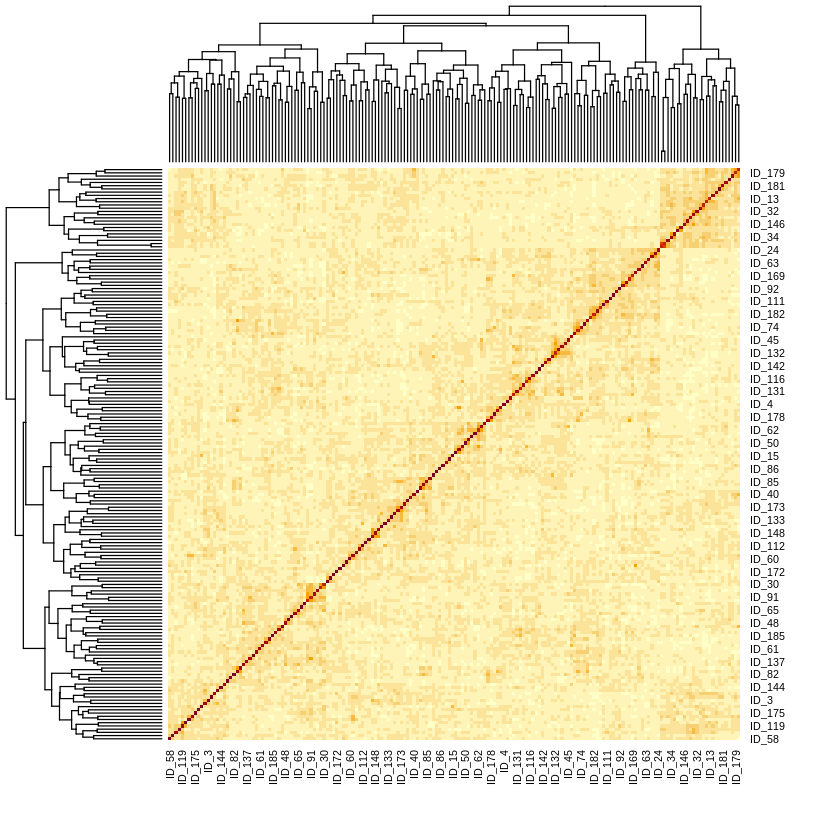

In [ ]:
### we can view the genomic relationship / population substructure using a heatmap
heatmap(grm)

---

## SECTION IV:  RUN A GWAS AND GENERATE A MANHATTAN PLOT TO IDENTIFY POTENTIAL PEAKS

We pick one phenotype from our dataset and use it to run the GWAS:

In [ ]:
head(phenotypes)

### Phenotypes data frame for GWAS in rrBLUP
phe_gwas <- data.frame(id = phenotypes$Name, fruit_shape = phenotypes$fruit_shape)
head(phe_gwas)

,Name,yield,fruit_shape
,<chr>,<dbl>,<dbl>
1,ID_1,13.10,4.71
2,ID_2,15.56,3.59
3,ID_3,11.77,4.07
4,ID_4,13.43,2.81
5,ID_5,12.58,2.81
7,ID_7,12.56,4.73


,id,fruit_shape
,<chr>,<dbl>
1,ID_1,4.71
2,ID_2,3.59
3,ID_3,4.07
4,ID_4,2.81
5,ID_5,2.81
6,ID_7,4.73


In [ ]:
### Genotypes data frame for GWAS in rrBLUP

### select SNPs that were not filtered out
vec <- map$marker %in% colnames(g_mat_imputed)
map_filtered = map[vec,]

geno_gwas <- data.frame(map_filtered, t(g_mat_imputed))
geno_gwas[1:5, 1:6]

,marker,chrom,pos,ID_1,ID_2,ID_3
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,SNP_1,1,1,-5.551115e-17,-5.551115e-17,-0.6787879
3,SNP_3,1,3,0.000000e+00,0.000000e+00,0.0000000
6,SNP_6,1,6,1.000000e+00,1.000000e+00,1.0000000
7,SNP_7,1,7,-1.000000e+00,-1.000000e+00,-1.0000000
8,SNP_8,1,8,0.000000e+00,0.000000e+00,0.0000000


### 1. Run GWAS

In [ ]:
time_rrBLUP <- Sys.time()                          # measure computation time
gwas_rrblup <- rrBLUP::GWAS(pheno = phe_gwas,
                            geno = geno_gwas,
                            K = grm,               # A.mat generated by default if K not provided.
                            fixed = NULL,          # fixed effects?
                            plot = FALSE)
time_rrBLUP <- Sys.time() - time_rrBLUP

time_rrBLUP

[1] "GWAS for trait: fruit_shape"
[1] "Variance components estimated. Testing markers."


Time difference of 2.083435 secs

In [ ]:
## Set threshold for Bonferroni correction
bonf <- -log10(0.05 / nrow(geno_gwas))
print(bonf)

[1] 4.666143


In [ ]:
gwas_res <- gwas_rrblup
names(gwas_res) <- c("SNP","CHR","BP","P")
head(gwas_res)

,SNP,CHR,BP,P
,<chr>,<int>,<int>,<dbl>
1,SNP_1,1,1,0.05849045
3,SNP_3,1,3,0.33292440
6,SNP_6,1,6,0.14710743
7,SNP_7,1,7,0.43758760
8,SNP_8,1,8,0.08755850
9,SNP_9,1,9,0.71403988


In [ ]:
## rrBLUP calculates -log10(p) values. These are converted into p-values.
gwas_res$P <- 10^((-gwas_res$P))
head(gwas_res)

,SNP,CHR,BP,P
,<chr>,<int>,<int>,<dbl>
1,SNP_1,1,1,0.8739962
3,SNP_3,1,3,0.4645961
6,SNP_6,1,6,0.7126767
7,SNP_7,1,7,0.3651005
8,SNP_8,1,8,0.8174129
9,SNP_9,1,9,0.1931791


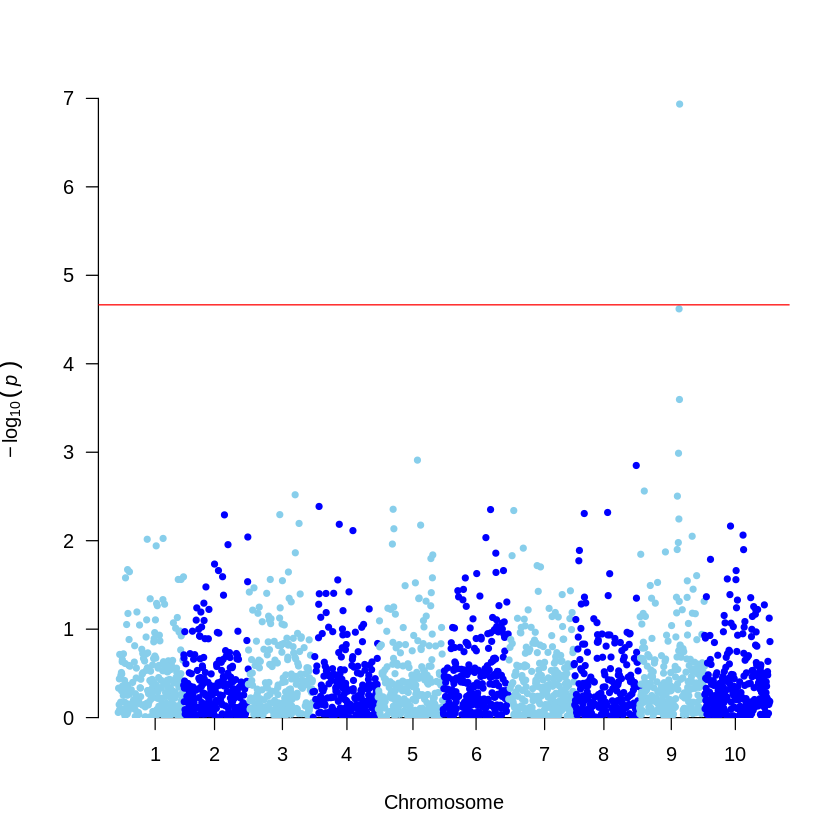

In [ ]:
## Manhattan plot of -log10(p)-values
qqman::manhattan(gwas_res,
                 suggestiveline = FALSE,
                 col = c("skyblue","blue"),
                 genomewideline = bonf,
                 logp = TRUE)

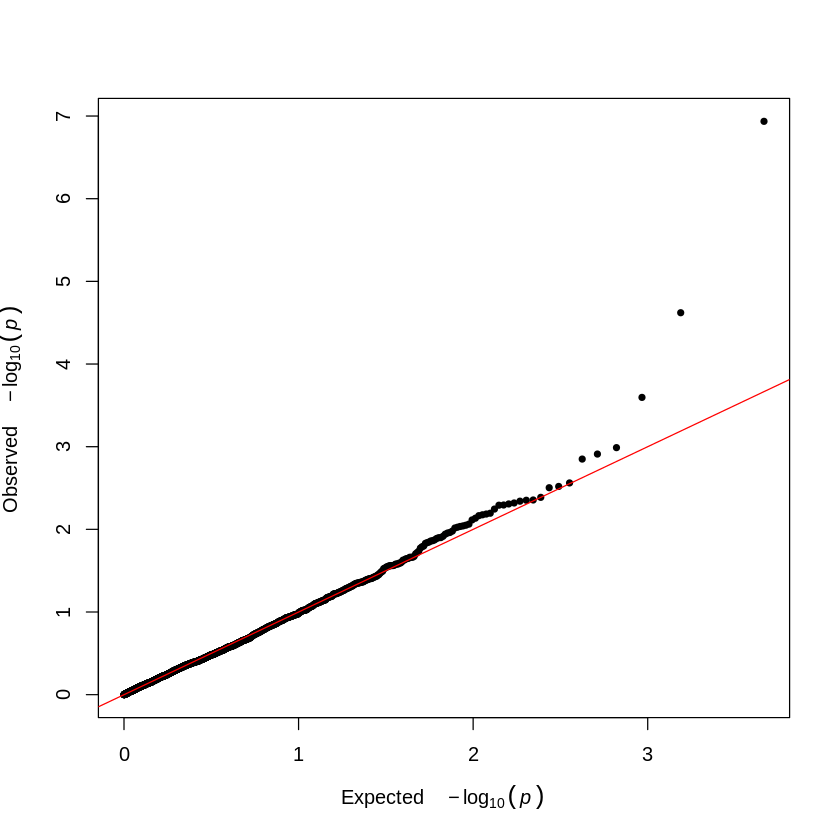

In [ ]:
## qq-plot
qqman::qq(gwas_res$P)

### 2. GWAS control scenario: no correction for population structure

!!Mind: rrBLUP will automatically calculate the GRM if no relationship matrix is provided.
We can enforce a regression without correction for population structure if we provide a diagonal matrix instead of the GRM.


In [ ]:
relMat_diag <- diag(nrow(grm))
colnames(relMat_diag) <- rownames(relMat_diag) <- colnames(grm)
str(relMat_diag)

 num [1:178, 1:178] 1 0 0 0 0 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:178] "ID_1" "ID_2" "ID_3" "ID_4" ...
  ..$ : chr [1:178] "ID_1" "ID_2" "ID_3" "ID_4" ...


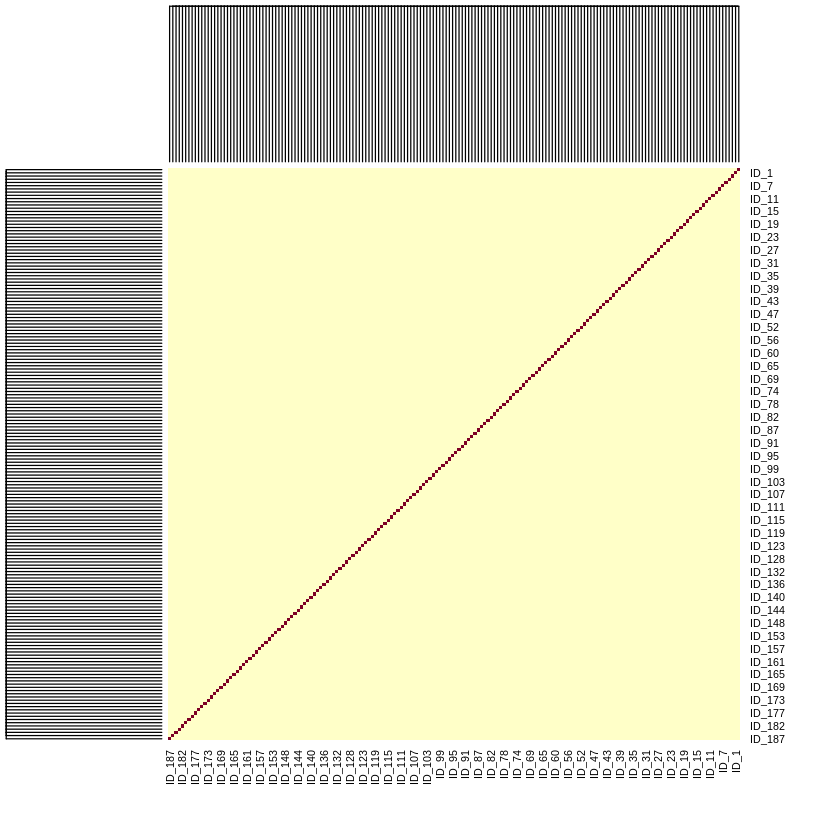

In [ ]:
heatmap(relMat_diag)

In [ ]:
gwas_rrblup_2 <- rrBLUP::GWAS(pheno = phe_gwas,
                              geno = geno_gwas,
                              K = relMat_diag,       # Assumption: unrelated individuals.
                              fixed = NULL,          # fixed effects?
                              plot = FALSE)

[1] "GWAS for trait: fruit_shape"
[1] "Variance components estimated. Testing markers."


In [ ]:
gwas_res_2 <- gwas_rrblup_2
names(gwas_res_2) <- c("SNP","CHR","BP","P")

In [ ]:
## rrBLUP calculates -log10(p) values. These are converted into p-values.
gwas_res_2$P <- 10^((-gwas_res_2$P))

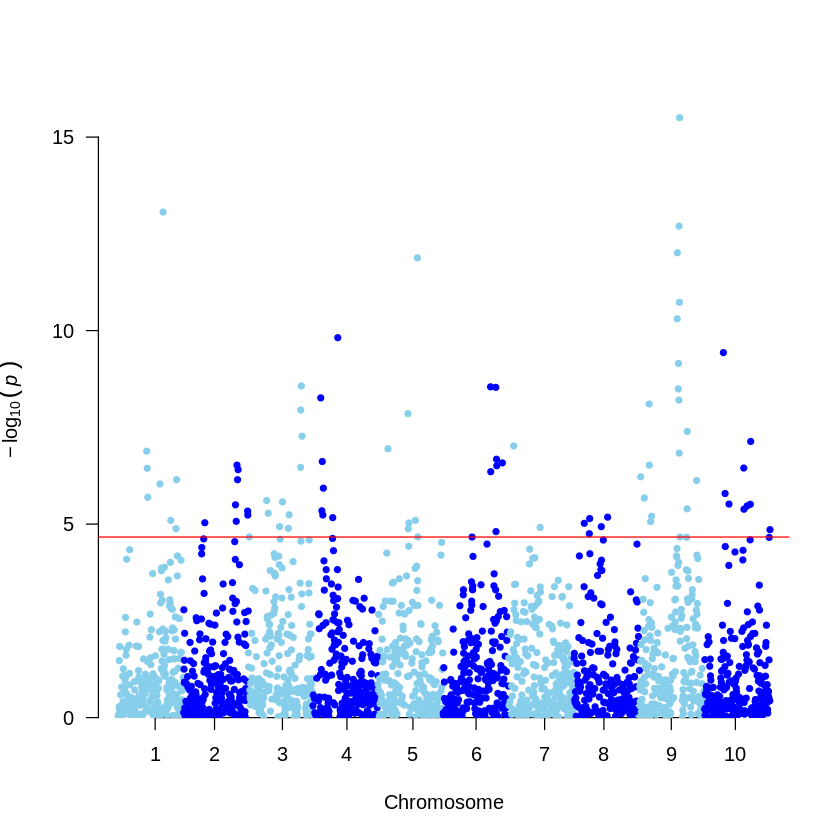

In [ ]:
## Manhattan plot of -log10(p)-values
qqman::manhattan(gwas_res_2,
          suggestiveline = FALSE,
          col = c("skyblue","blue"),
          genomewideline = bonf,
          logp = TRUE)

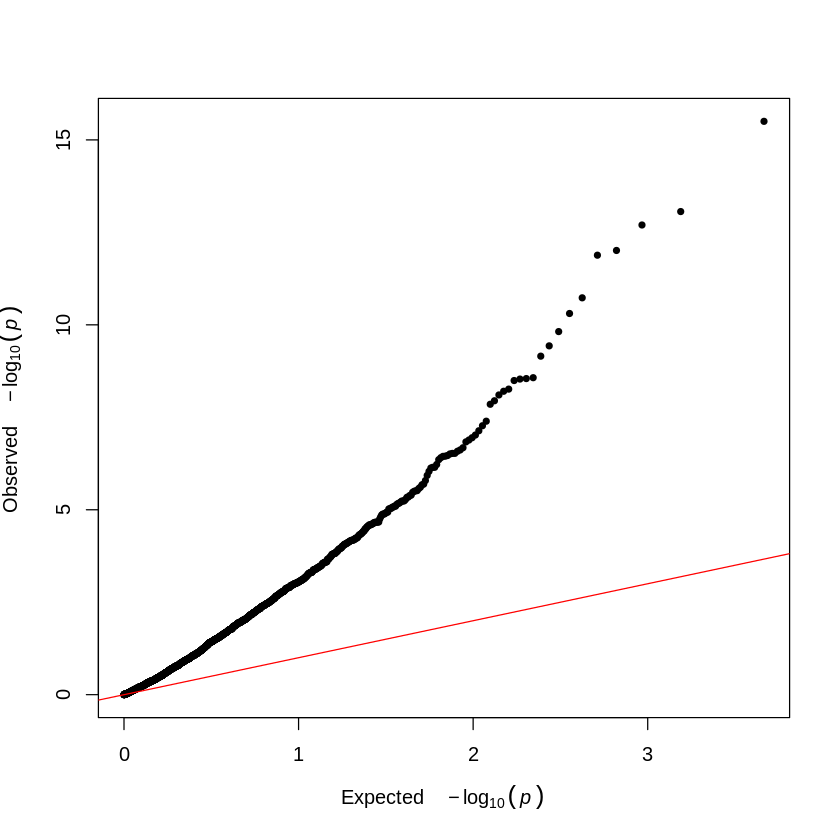

In [ ]:
## qq-plot
qqman::qq(gwas_res_2$P)

## SECTION V: DO IT YOURSELF

- `map_fruit_sim.csv`
- `genotypes_fruit_sim.csv`
- `phenotypes_fruit_sim.csv`

In [ ]:
 #### Read the data

# +
# genotypes <-
# map <-
# phenotypes <-
# -

In [ ]:
#### Explore and describe
#
# - how many?
# - what?
# - have a look? e.g. summary stats, visualization

In [ ]:
print(paste("N. of genotyped samples:", nrow(genotypes)))
print(paste("N. of phenotyped samples:", nrow(phenotypes)))
print(paste("N. of SNPs:", nrow(map)))

In [ ]:
#### Recode and filter

# +
## your code
# -

In [ ]:
#### Impute missing genotypes and calculate the

# +
## your code
# -

In [ ]:
# #### Run GWAS

# +
## your code
# -


In [ ]:
# #### Evaluate results

# +
## your code